## 1 optimizing code for a NN with a custom topology

In [1]:
import sys                                              # to run an early exit later
import os
import time
from IPython.display import display_svg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from PIL import Image
from collections import defaultdict
from datetime import datetime
from graphviz import Digraph

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split

# custom packages
from Custom_packages.torchviz_v2 import Dot_graph
from Custom_packages.DAG import Graph

# device configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#torch.manual_seed(2)

# display with the graphics library integrated in Notebook
%matplotlib inline
#%matplotlib widget

# disable a process that slow down the intellisense in Jupyter Notebook
%config Completer.use_jedi = False    

# random seed
np.random.seed(np.random.randint(0, 10000))

### 1.1 code based on topological order and node-wise operation

In [95]:

class function_approximator(nn.Module):
    def __init__(self, 
                 adjacency_matrix: np.ndarray,
                 output_node: int=None):
        super().__init__()
        
        self.graph = None
        
        t_start = time.time()
        
        self.num_nodes = None
        self.num_edges = None
            
        # information of the input and output layers
        self.input_nodes = None
        self.dim_input = None                               # number of features
        self.output_node = None
        self.dim_output = None
    
        # setting the parameters of the neural network
        self.weights = None
        self.non_zero_entries = None
        self.weight_names = None
            
        self.biases = None
        self.bias_names = None
            
        # mapping the parameters to a directed acyclic graph
        self.graph = None
        self.bias_idx = None   # dictionary containing the index of the hidden nodes
        self.order = None
        self.list_node_values = None          # list with the values calculated at each node and epoch

        self.change_topology(adjacency_matrix)
            
        t_end = time.time()
        print("time - initialization of the NN: ",t_end - t_start)
            
    def reset_parameters(self,distribution=["normal","normal"],
                         params=[[0.0,1.0],[0.0,1.0]]) -> None:
        
        if(distribution[0] == "uniform"):
            nn.init.uniform_(self.weights, a=params[0][0], b=params[0][1])
        elif(distribution[0] == "normal"):
            nn.init.normal_(self.weights, mean=params[0][0], std=params[0][1])
        
        if self.biases is not None:
            if(distribution[1] == "uniform"):
                nn.init.uniform_(self.biases, a=params[1][0], b=params[1][1])
            elif(distribution[1] == "normal"):   
                nn.init.normal_(self.biases, mean=params[1][0], std=params[1][1])
            
                
            
    def forward(self, 
                x_tt: torch.Tensor) -> torch.Tensor:
        
#         t_start = time.time()
        # number of instances
        num_instances = 1
        if(len(x_tt.size()) > 1):
            num_instances = x_tt.size()[0]
        
        # add the input values (x_tt) to the input nodes
        for i in range(self.dim_input):
            if(len(x_tt.size()) > 1):
                self.list_node_values[self.input_nodes[i]] = x_tt[:,i]
            else:
                self.list_node_values[self.input_nodes[i]] = x_tt[i]
            
        # add a bias for each node u in the topological order
        # after that, add x_u*w_{u,v} to the value of the node v (neighbour of u)
        for u in self.order:
            if(u in self.bias_idx):      # if the node must have a bias associated (hidden node)
                if(u not in self.list_node_values):     # if the variable to stock the results is not initialized
                    self.list_node_values[u] = self.biases[self.bias_idx[u]]
                else:
                    self.list_node_values[u] += self.biases[self.bias_idx[u]]
                    
                # application of the activation function
                if(u != self.output_node):
                    #self.list_node_values[u] = torch.relu(self.list_node_values[u]+1/2)-torch.relu(self.list_node_values[u]-1/2)
                    #self.list_node_values[u] = torch.sigmoid(self.list_node_values[u])
                    self.list_node_values[u] = torch.relu(self.list_node_values[u])
                    
            for v in self.graph.adjacency_dict[u].keys():
                if(v not in self.list_node_values):
                    self.list_node_values[v] = self.list_node_values[u]*self.weights[self.graph.adjacency_dict[u][v]]
                else:
                    self.list_node_values[v] += self.list_node_values[u]*self.weights[self.graph.adjacency_dict[u][v]]
            
        # return a tensor with the values in the output nodes. In the general case (n instances and m outputs), 
        # the dimension of the output tensor will be n*m.
        with torch.no_grad():
            output = self.list_node_values[self.output_node]
        self.list_node_values.clear()
        
#         t_end = time.time()
#         print("time - forward step: ",t_end - t_start)
        
        if(self.dim_output==1):
            return output.view(num_instances)
        
        return output
    
    def loss(self,output,target,lambda_:float=0):
        loss = torch.sum((output-target)**2)+lambda_*torch.norm(self.weights,p=1)
        return loss

    def change_topology(self, 
                 adjacency_matrix: np.ndarray,
                 output_node: int=None,
                 reset_params: bool=True):

        if(adjacency_matrix is not None):
            # number of nodes and edges of the neural network
            self.num_nodes = len(adjacency_matrix)
            self.num_edges = adjacency_matrix.sum()
            
            # information of the input and output layers
            self.input_nodes = np.where(adjacency_matrix.sum(axis=0) == 0)[0]
            self.dim_input = len(self.input_nodes)                               # number of features
            if output_node is None:
                self.output_node = np.where(adjacency_matrix.sum(axis=1) == 0)[0][0]
            else:
                self.output_node = output_node
            self.dim_output = 1
    
            # setting the parameters of the neural network
            if(reset_params):
                self.weights = nn.parameter.Parameter(torch.empty(size=(self.num_edges,)))
                self.non_zero_entries = np.where(adjacency_matrix > 0)
                self.weight_names =  np.array(['w_'+str(self.non_zero_entries[0][i])+","+str(self.non_zero_entries[1][i]) for i in range(len(self.non_zero_entries[0]))])
                
                self.biases = nn.parameter.Parameter(torch.empty(size=(self.num_nodes-self.dim_input,)))
                self.bias_names = np.array(["b_"+str(i) for i in range(self.dim_input,self.num_nodes)])
                self.reset_parameters()
                print("Parameters have been reset.")
            
            # mapping the parameters to a directed acyclic graph
            self.graph = Graph(adjacency_matrix=adjacency_matrix)
            edge_iter = 0      # edge iterator
            for u in self.graph.adjacency_dict.keys():
                for v in self.graph.adjacency_dict[u].keys():
                    self.graph.adjacency_dict[u][v] = edge_iter
                    edge_iter += 1
                
            self.bias_idx = defaultdict(dict)   # dictionary containing the index of the hidden nodes
            bias_idx = 0      # node iterator
            for node_idx in range(self.dim_input, self.num_nodes):
                self.bias_idx[node_idx] = bias_idx
                bias_idx += 1
                    
            self.order = self.graph.topologicalSort()
            self.list_node_values = defaultdict(torch.tensor)            # list with the values calculated at each node and epoch
        
        
        else:
            print("Please provide a valid structure to the model.")
    
#     def zero_op(self,epsilon):
        
#         # apply zero operation to an edge/node
#         zeroed_weights_idx = []
#         zeroed_biases_idx = []
        
#         with no_grad():
#             for i in range(len(self.weights)):
#                 if(self.weights[i] <= epsilon):
#                     self.weights[i] = self.weights[i]*0.0
#                     zeroed_weights_idx.append(i)
                    
#             for j in range(len(self.biases)):
#                 if(self.biases[j] <= epsilon):
#                     self.biases[j] = self.biases[j]*0.0
#                     zeroed_biases_idx.append(j)
        
#         # update topology
        
                
     

### 1.2 code based on node-wise activation function on virtual nodes

In [12]:

# class function_approximator_2(nn.Module):
#     def __init__(self, 
#                  adjacency_matrix: np.ndarray,
#                  output_node: int=None):
#         super().__init__()
        
#         self.graph = None
#         t_start = time.time()
        
#         if(adjacency_matrix is not None):
#             # number of nodes and edges of the neural network
#             self.num_nodes = len(adjacency_matrix)
#             self.num_edges = adjacency_matrix.sum()
            
#             # information of the input and output layers
#             self.input_nodes = np.where(adjacency_matrix.sum(axis=0) == 0)[0]
#             self.dim_input = len(self.input_nodes)                               # number of features
#             if output_node is None:
#                 self.output_node = np.where(adjacency_matrix.sum(axis=1) == 0)[0][0]
#             else:
#                 self.output_node = output_node
#             self.dim_output = 1
    
#             # setting the parameters of the neural network
#             self.weights = nn.parameter.Parameter(torch.empty(size=(self.num_edges,)))
#             self.non_zero_entries = np.where(adjacency_matrix > 0)
#             self.weight_names =  np.array(['w_'+str(self.non_zero_entries[0][i])+","+str(self.non_zero_entries[1][i]) for i in range(len(self.non_zero_entries[0]))])
            
#             self.biases = nn.parameter.Parameter(torch.empty(size=(self.num_nodes-self.dim_input,)))
#             self.bias_names = np.array(["b_"+str(i) for i in range(self.dim_input,self.num_nodes)])
#             self.reset_parameters()
            
#             # mapping the parameters to a directed acyclic graph
#             self.graph = Graph(adjacency_matrix=adjacency_matrix)
#             edge_iter = 0      # edge iterator
#             for u in self.graph.adjacency_dict.keys():
#                 for v in self.graph.adjacency_dict[u].keys():
#                     self.graph.adjacency_dict[u][v] = edge_iter
#                     edge_iter += 1
                
#             self.bias_idx = defaultdict(dict)   # dictionary containing the index of the hidden nodes
#             bias_idx = 0      # node iterator
#             for node_idx in range(self.dim_input, self.num_nodes):
#                 self.bias_idx[node_idx] = bias_idx
#                 bias_idx += 1
                    
#             self.order = self.graph.topologicalSort()
#             self.list_node_values = defaultdict(torch.tensor)            # list with the values calculated at each node and epoch
        
        
#         else:
#             print("Please provide a valid structure to the model.")
            
#         t_end = time.time()
#         print("time - initialization of the NN: ",t_end - t_start)
            
#     def reset_parameters(self,distribution=["normal","normal"],
#                          params=[[0.0,1.0],[0.0,1.0]]) -> None:
        
#         if(distribution[0] == "uniform"):
#             nn.init.uniform_(self.weights, a=params[0][0], b=params[0][1])
#         elif(distribution[0] == "normal"):
#             nn.init.normal_(self.weights, mean=params[0][0], std=params[0][1])
        
#         if self.biases is not None:
#             if(distribution[1] == "uniform"):
#                 nn.init.uniform_(self.biases, a=params[1][0], b=params[1][1])
#             elif(distribution[1] == "normal"):   
#                 nn.init.normal_(self.biases, mean=params[1][0], std=params[1][1])
            
                
            
            
     
#     def forward(self, 
#                 x_tt: torch.Tensor) -> torch.Tensor:
        
#         t_start = time.time()
#         # number of instances
#         num_instances = 1
#         if(len(x_tt.size()) > 1):
#             num_instances = x_tt.size()[0]
        
#         # add the input values (x_tt) to the input nodes
#         for i in range(self.dim_input):
#             if(len(x_tt.size()) > 1):
#                 self.list_node_values[self.input_nodes[i]] = x_tt[:,i]
#             else:
#                 self.list_node_values[self.input_nodes[i]] = x_tt[i]
            
#         # add a bias for each node u in the topological order
#         # after that, add x_u*w_{u,v} to the value of the node v (neighbour of u)
#         for u in self.order:
#             if(u in self.bias_idx):      # if the node must have a bias associated (hidden node)
#                 if(u not in self.list_node_values):     # if the variable to stock the results is not initialized
#                     self.list_node_values[u] = self.biases[self.bias_idx[u]]
#                 else:
#                     self.list_node_values[u] += self.biases[self.bias_idx[u]]
#                     #self.list_node_values[u].add(self.biases[self.bias_idx[u]])
                    
#                 # application of the activation function
#                 if(u != self.output_node):
#                     self.list_node_values[u] = torch.sigmoid(self.list_node_values[u])
                    
#             for v in self.graph.adjacency_dict[u].keys():
#                 #print("v: {0}, tensor_list: {1}".format(v,self.list_node_values))
#                 if(v not in self.list_node_values):
#                     self.list_node_values[v] = self.list_node_values[u]*self.weights[self.graph.adjacency_dict[u][v]]
#                     #self.list_node_values[v].mul(self.weights[self.graph.adjacency_dict[u][v]])
#                 else:
#                     #print("v: ",v)
#                     #print(self.list_node_values[v].detach())
#                     self.list_node_values[v] += self.list_node_values[u]*self.weights[self.graph.adjacency_dict[u][v]]
#                     #self.list_node_values[v].add(self.list_node_values[u].mul(self.weights[self.graph.adjacency_dict[u][v]]))
            
#         # return a tensor with the values in the output nodes. In the general case (n instances and m outputs), 
#         # the dimension of the output tensor will be n*m.
#         with torch.no_grad():
#             output = self.list_node_values[self.output_node]
#         self.list_node_values.clear()
        
#         t_start = time.time()
#         print("time - forward step: ",t_end - t_start)
        
#         if(self.dim_output==1):
#             return output.view(num_instances)
        
        
#         return output
    
#     def loss(self,output,target,lambda_:float=0):
#         loss = torch.mean((output-target)**2)+lambda_*torch.norm(self.weights,p=2)
#         return loss

### 1.3 Code for training

In [61]:
import warnings
warnings.filterwarnings("error")

def save_plots_evolution(model,x_tt,X_1,X_2,X_c,
                        f_1:str,n_f:int,f_2:str,m_f:int,iter:int=0,
                        error_tr_evol=None,error_test_evol=None):

    fig = plt.figure(figsize=(17,7))

    ax_1 = fig.add_subplot(1,3,1,projection='3d')
    x_1 = X_1.reshape(-1,1)
    x_2 = X_2.reshape(-1,1)
    X_c = torch.tensor([[x_1[i,0],x_2[i,0]] for i in range(X_1.shape[0]*X_1.shape[1])]).to(device)

    Z = model(X_c).detach().numpy().reshape(X_1.shape)

    ax_1.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)
                
    # set axes label
    ax_1.set_xlabel('x',labelpad=20)
    ax_1.set_ylabel('y',labelpad=20)
    ax_1.set_zlabel('z',labelpad=20)
    #ax_1.set_zlim(-2.0, 2.0)
    ax_1.set_title('Approximation')

    if(error_tr_evol is not None and error_test_evol is not None):
        plot_error([error_tr_evol[0][1:]],[error_test_evol[0][1:]],fig,1,3,2)
    #plot_error(error_tr_evol,error_test_evol,fig,1,3,2)

    #os.makedirs('./Images_runs')

    plt.savefig("./Images_runs/error_"+str(f_1)+"_"+str(n_f)+"_"+str(f_2)+"_"+str(m_f)+"_"+str(iter)+".png")
    #plt.show()
    plt.close()

    # values of the topology 1
    x_tt = X_c[0]
    graph_graphviz_v2 = Dot_graph(model(x_tt), model=model, instance=x_tt,show_attrs=False, show_saved=False)
    #resize_graph(graph_graphviz, size_per_element=2, min_size=20)
    graph_plot_gp2 = graph_graphviz_v2.make_dot_nn(instantiated=True)
    graph_plot_gp2.render(filename="./Images_runs/network_"+str(f_1)+"_"+str(n_f)+"_"+str(f_2)+"_"+str(m_f)+"_"+str(iter),format="png")


def train_model(X_tr,Y_tr,X_test,Y_test,error:float,max_epochs:int,topologies:list,learning_rates:list,
                lambda_:float=0,gamma_:float=0,num_epochs_not_seen:int=1000,num_sampling:int=50,batch_size:int=1,
                X_1=None,X_2=None,X_c=None,f_1='',n_f=0,f_2='',m_f=0,num_plotting=128):
    '''
    lambda_: regularization parameter (norm 2)
    gamma_: weight decay parameter
    num_plotting: frequence of image sampling
    '''

    # data as tensors
    x_tt = torch.Tensor(X_tr).to(device)
    y_tt = torch.Tensor(Y_tr).to(device)
    x_test_tt = torch.Tensor(X_test).to(device)
    y_test_tt = torch.Tensor(Y_test).to(device)
    
    num_steps = len(X_tr)
    #num_steps = int(np.floor(len(X_tr)/batch_size))            # this is a model with a single batch and num_steps is the his size
    idx_list = np.arange(num_steps)          # index of the elements in the batch
    date = datetime.now()

    idx_topo = 0
    
    # variables for sampling
#     num_epochs_not_seen = 1000   # frequency of the sampling for tensorboard
#     num_sampling = 50 # frequency of sampling for weights and biases evolution
    
    # lists for recording the results
    list_models = []
    list_error_models = []
    list_error = []
    list_error_test_models = []
    list_error_test = []
    list_weight_values_models = []
    list_weight_values = []
    list_bias_values_models = []
    list_bias_values = []
    list_epochs = []
    

    ## training phase
    for topo in topologies:
        # change the topologie of the network
        neural_network_graph = topo
        model = function_approximator(neural_network_graph).to(device)

        for l_r in learning_rates:
            # instatiation of the weights
            model.reset_parameters()
            
            loss = error + 1
            epochs = 0
            
            # parameter for early stopping after each epoch
            best_loss_test = np.inf             
            loss_test = 0.0
            isOverfitted = False
            
            #optimizer = torch.optim.SGD(model.parameters(), lr=l_r)
            optimizer = torch.optim.Adam(model.parameters(), lr=l_r, weight_decay=gamma_)

            while(loss > error and epochs < max_epochs):
                
                # saving images about the evolution of the error, the function and the architecture
                #if(epochs%num_plotting==0 or float(np.log2(epochs)).is_integer()):
                if(epochs == 0 or float(np.log2(epochs)).is_integer()):
                    save_plots_evolution(model,x_tt[0],X_1,X_2,X_c,
                            f_1,n_f,f_2,m_f,epochs,[list_error],[list_error_test])

                # sorting indirectly the points evaluated at each epoch in order to make the output model more general
                np.random.shuffle(idx_list)
                for j in range(num_steps):
                    data_point = idx_list[j]
                    #data_point = np.random.randint(len(X))
                    x_var = x_tt[data_point].float()
                    y_var = y_tt[data_point].float()

                    optimizer.zero_grad()                               # make the gradient vector zero at the beginning
                    y_hat = model(x_var)                                # forward phase

                    loss = model.loss(y_hat, y_var, lambda_)
                    loss.backward(retain_graph=False)                   # backward phase
                    optimizer.step()                                    # weight ajustement

                    if(int(epochs*num_steps + j) % num_sampling == 0):
                        
                        #  update error on validation data
                        with torch.no_grad():
                            y_hat_test = model(x_test_tt)
                            loss_test = model.loss(y_hat_test, y_test_tt, lambda_)
                            if(loss_test < best_loss_test):
                                best_loss_test = loss_test
#                             else:
#                                 print("loss_test: ",loss_test,", best_loss_test: ",best_loss_test)
#                                                                 isOverfitted = True
                        
                        
                        list_error.append(loss.cpu().item())
                        list_error_test.append(loss_test)
                        list_weight_values.append(list(model.weights.cpu().data.numpy()))
                        list_bias_values.append(list(model.biases.cpu().data.numpy()))

                    if(int(epochs*num_steps + j) % num_epochs_not_seen == 0):
                        print('{:<3}{:<2} {:<4}{:<6} {:<6}{:<12} {:<6}{:<12}'.format("Epoch:",epochs,"Step:",j,"Train loss:",np.round(float(loss.cpu().data.numpy()),5),"Test loss:",np.round(float(loss_test),5)))

                    elif(epochs*num_steps + j == epochs*num_steps-1):
                        #print('Epoch: {0},\tStep: {1},\tTrain loss: {2}\tTest loss: {3}'.format(epochs, j, loss.cpu().data.numpy(),loss_test))
                        print('{:<3}{:<2} {:<4}{:<6} {:<6}{:<12} {:<6}{:<12}'.format("Epoch:",epochs,"Step:",j,"Train loss:",np.round(float(loss.cpu().data.numpy()),5),"Test loss:",np.round(float(loss_test),5)))                        
                    

                epochs += 1
                
                # # stop training if the model is overfitted
                # if(isOverfitted and loss_test >= best_loss_test):
                #     print("Early stop at epoch: ",epochs)
                #     break
                # elif(isOverfitted and loss_test < best_loss_test):
                #     isOverfitted = False

            list_models.append(model)
            list_error_models.append(list_error)
            list_error = []
            list_error_test_models.append(list_error_test)
            list_error_test = []
            list_weight_values_models.append(list_weight_values)
            list_weight_values = []
            list_bias_values_models.append(list_bias_values)
            list_bias_values = []
            list_epochs.append(epochs)
        

        idx_topo += 1
    
    return list_models,list_error_models,list_error_test_models,list_weight_values_models,list_bias_values_models,list_epochs

### 1.4 Code to create custom neural network architectures

In [5]:
# define a function to get a classical feed-forward neural network topology
def sequential_DAG(dim_input: int=1,units_in_layers=[3],dim_output: int=1):
    dim = dim_input + sum(units_in_layers) + dim_output 
    topology = np.zeros((dim,dim))
    
    # connect the input nodes to the following nodes
    for i in range(dim_input):
        for j in range(dim_input,dim_input+units_in_layers[0]):
            topology[i,j] = 1
            
    # connect the nodes in the hidden layers to the following nodes (in a path)
    units_seen = dim_input
    for idx_units in range(len(units_in_layers)):
        if(idx_units < len(units_in_layers) - 1):
            units_next_layer = units_in_layers[idx_units+1]
        else:
            units_next_layer = dim_output
        current_units = units_seen+units_in_layers[idx_units]
        for i in range(units_seen,current_units):
            for j in range(current_units,current_units+units_next_layer):
                topology[i,j] = 1
        units_seen += units_in_layers[idx_units]

    return np.array(topology,dtype=int)


# # define a function to get a topology where a node is connected to all the nodes in following layers
# def fully_connected_DAG(dim_input: int=1,dim_output: int=1,units_in_layers:list=None, num_nodes: int=3):
    
#     if(units_in_layers is None):
#         units_in_layers = [1 for i in range(num_nodes-dim_input-dim_output)]
    
#     dim = dim_input + sum(units_in_layers) + dim_output 
#     topology = np.zeros((dim,dim))
    
#     # connect the input nodes to the following nodes
#     for i in range(dim_input):
#         for j in range(dim_input,dim):
#             topology[i,j] = 1
            
#     # connect the nodes in the hidden layers to the following nodes (in a path)
#     units_seen = dim_input
#     for units in units_in_layers:
#         for i in range(units_seen,units_seen+units):
#             for j in range(units_seen+units,dim):
#                 topology[i,j] = 1
#         units_seen += units

#     return np.array(topology,dtype=int)

def fully_connected_DAG(dim_input: int=1,units_in_layers=[3],dim_output: int=1):
    dim = dim_input + sum(units_in_layers) + dim_output 
    topology = np.zeros((dim,dim))
    
    # connect all the nodes sequentially (1 node in each layer except by the input layer)
    for i in range(dim):
        for j in range(max(dim_input,i+1),dim):
            topology[i,j] = 1

    return np.array(topology,dtype=int)

def topology_to_binary(topology: np.ndarray):
    binary_rep = ""
    for row in range(len(topology)):
        for column in range(len(topology[row])):
            binary_rep += str(topology[row,column])
    return binary_rep

### 1.5 Code to plot the weight and error evolution

In [6]:
def plot_weight_evolution(list_weight_values_models,list_bias_values_models,
                          weight_names_models=None,bias_names_models=None,input_dim=2,fig=None):
    
    n_models = len(list_weight_values_models)
    n_cols = 2
    n_rows = n_models
    
    if fig is None:
        fig = plt.figure(figsize=(8*n_cols,6.4*n_rows))
        
    for idx_model in range(len(list_weight_values_models)):
        ax = fig.add_subplot(n_rows,n_cols,2*idx_model+1)
        list_weights = np.array(list_weight_values_models[idx_model]).T

        if(weight_names_models is not None):
            for idx_weight in range(len(weight_names_models[idx_model])):
                ax.plot(list_weights[idx_weight],label=weight_names_models[idx_model][idx_weight])
        else:
            for idx_weight in range(len(list_weights)):
                ax.plot(list_weights[idx_weight],label="w_"+str(idx_weight))
        
        ax.legend(loc="upper right")
        ax.set_title('Weight evolution - Topology '+str(idx_model+1))
        
        ax = fig.add_subplot(n_rows,n_cols,2*idx_model+2)
        list_biases = np.array(list_bias_values_models[idx_model]).T
        
        if(bias_names_models is not None):
            for idx_bias in range(len(list_biases)):
                ax.plot(list_biases[idx_bias],label=bias_names_models[idx_model][idx_bias])        
        else:
            for idx_bias in range(len(list_biases)):
                ax.plot(list_biases[idx_bias],label="b_"+str(input_dim+idx_bias))
        
        ax.legend(loc="upper right")
        ax.set_title('Weight evolution - Topology '+str(idx_model+1))
    
    plt.savefig("nodes"+str(input_dim+len(list_biases))+"_regularization"+str(0.0)+"_weight-decay"+str(1.0)+".jpg")
    plt.show()


def plot_error(list_error_models,list_error_test_models,fig=None,n_rows=1,n_cols=2,num_subplots=0):
    
    '''
    num_subplots: num of existing subplots in fig (if it is not None)
    '''

    if fig is None:
        fig = plt.figure(figsize=(8*n_cols,6.4*n_rows))
        n_models = len(list_error_models)
        n_cols = 2
        n_rows = n_models
        
    for idx_model in range(len(list_error_models)):
        # training error
        ax = fig.add_subplot(n_rows,n_cols,2*idx_model+1+num_subplots)
        list_errors = np.array(list_error_models[idx_model]).T
        ax.plot(list_errors,label="training error")
        ax.legend(loc="upper right")
        ax.set_title('Error - Topology '+str(idx_model+1))
        
        # test error
        ax = fig.add_subplot(n_rows,n_cols,2*idx_model+2)
        list_errors_test = np.array(list_error_test_models[idx_model]).T
        ax.plot(list_errors_test,label="test error",color="red")
        ax.legend(loc="upper right")
        ax.set_title('Error - Topology '+str(idx_model+1))
        
    
    # plt.savefig("error_test1.jpg")
    # plt.show()


def plot_predictions(models:list,
                     topologies:list,
                     list_error:list,
                     x_1_lim:list=[-1,1],
                     x_2_lim:list=[-1,1],
                     zlim:list=[-1,1],
                     x_1_points:int=100,
                     x_2_points:int=100,
                     f_1:str='',
                     n_f:int=0,
                     f_2:str='',
                     m_f:int=0,
                     instance:int=0,
                     fig=None):
    
    n_models = len(models)
    n_cols = min(n_models,2)
    n_rows = np.ceil(n_models/n_cols)
    
    if fig is None:
        fig = plt.figure(figsize=(8.5*n_cols,7*n_rows))
    
    x_1 = np.linspace(x_1_lim[0],x_1_lim[1],x_1_points)
    x_2 = np.linspace(x_2_lim[0],x_2_lim[1],x_2_points)
    X_1,X_2 = np.meshgrid(x_1,x_2)
    Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

    X_100 = []
    for i in range(len(x_1)):
        for j in range(len(x_2)):
            X_100.append([x_1[i],x_2[j]])
    
    for idx_model in range(n_models):
        z_pred = models[idx_model](torch.Tensor(X_100).to(device))
        error = models[idx_model].loss(torch.tensor(Z).reshape(-1,1),Z_pred)
        Z_pred = z_pred.detach().numpy() 
        Z_pred = Z_pred.reshape((len(x_1),len(x_2)))
        

        ax = fig.add_subplot(n_rows,n_cols,idx_model+1,projection='3d')
        surf = ax.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)

        # set axes label
        ax.set_xlabel('x',labelpad=20)
        ax.set_ylabel('y',labelpad=20)
        ax.set_zlabel('z',labelpad=20)
        ax.set_zlim(-2.5, 2.5)
        neurons = len(topologies[idx_model])
        connections = np.sum(topologies[idx_model])
        ax.set_title('Prediction - Topology '+str(idx_model+1)+' : connections = '+str(connections)+' and training error = '+str(round(error,10)))
    
    plt.savefig("./Images_runs/comparison_topologies_nodes_"+str(neurons)+"_edges_"+str(connections)+"_"+f_1+"_"+str(n_f)+"_"+f_2+"_"+str(m_f)+"regularized_1E-4_instance_"+str(instance))
    plt.show()
    plt.close()

## 2. Testing (Barron,1993-1994) bound with the 2D fourier basis

### 2.1. Code to plot the 2D basis functions for each n,m

In [7]:
## mapping the image of a function to a 2D image. These functions form a basis of L^2([-1,1]) 
# if multiplied by an appropriate normalization factor:
# f1:(x,y) -> cos(n*x)*cos(m*y) for all n,m>=0
# f2:(x,y) -> cos(n*x)*sin(m*y) for all n>=0, m>=1
# f3:(x,y) -> sin(n*x)*cos(m*y) for all n>=1, m>=0
# f4:(x,y) -> sin(n*x)*sin(m*y) for all n,m>=1

def plot_base_function(X1:np.ndarray,X2:np.ndarray,n=1,m=1,limits_x_1=[-1,1],limits_x_2=[-1,1], 
                       fig=None,fig_size=None,fig_res=None):
    """Plots the decision function of the neural network with respect to a forward function
    
    input:
        n,m := parameter of the functions cos(n*x)*cos(m*y)
        fig (plt.figure): optional, usefull if you dont want to generate any new figure, 
                    in the case of suplots.
    """
    
    low1, high1 = limits_x_1[0], limits_x_1[1]
    low2, high2 = limits_x_2[0], limits_x_2[1]    
    
    fig = plt.figure(figsize=fig_size,dpi=fig_res)
#     if fig is None:
#         if(fig_size is not None):
#             if(fig_res is not None):
#                 fig = plt.figure(figsize=fig_size,dpi=fig_res)
#             else:
#                 fig = plt.figure(figsize=fig_size)
#         elif(fig_res is not None):
#             fig = plt.figure(dpi=fig_res)
#         else:
#             fig = plt.figure() # default size: (6.4, 4.8) inches with 100 dpi, so 
    
    # plotting cos(n*x)*cos(m*y)
    y = np.cos(n*np.pi*X1)*np.cos(m*np.pi*X2)
    ax = fig.add_subplot(1,1,1)
    image = ax.imshow(y, extent=(low1,high1,low2,high2),vmin=-1,vmax=1,
                      cmap='gray',origin='lower', interpolation='gaussian')
    
    #fig.colorbar(image, cax=ax, shrink=0.5, aspect=8)
    plt.axis('off')
    plt.savefig("Sample_functions/cos_{0}_cos_{1}.jpg".format(n,m))
    plt.show()
    plt.close()
    
    # plotting cos(n*x)*sin(m*y)
    if(m >= 1):
        fig = plt.figure(figsize=fig_size,dpi=fig_res)
        y = np.cos(n*np.pi*X1)*np.sin(m*np.pi*X2)
        ax = fig.add_subplot(1,1,1)
        image = ax.imshow(y, extent=(low1,high1,low2,high2),vmin=-1,vmax=1,
                          cmap='gray',origin='lower', interpolation='gaussian')

        #fig.colorbar(image, cax=ax, shrink=0.5, aspect=8)
        plt.axis('off')
        plt.savefig("Sample_functions/cos_{0}_sin_{1}.jpg".format(n,m))
        plt.show()
        plt.close()
        
    
    # plotting sin(n*x)*cos(m*y)
    if(n >= 1):
        fig = plt.figure(figsize=fig_size,dpi=fig_res)
        y = np.sin(n*np.pi*X1)*np.cos(m*np.pi*X2)
        ax = fig.add_subplot(1,1,1)
        image = ax.imshow(y, extent=(low1,high1,low2,high2),vmin=-1,vmax=1,
                          cmap='gray',origin='lower', interpolation='gaussian')

        #fig.colorbar(image, cax=ax, shrink=0.5, aspect=8)
        plt.axis('off')
        plt.savefig("Sample_functions/sin_{0}_cos_{1}.jpg".format(n,m))
        plt.show()
        plt.close()
    
    # plotting sin(n*x)*sin(m*y)
    if(n >= 1 and m >= 1):
        fig = plt.figure(figsize=fig_size,dpi=fig_res)
        y = np.sin(n*np.pi*X1)*np.sin(m*np.pi*X2)
        ax = fig.add_subplot(1,1,1)
        image = ax.imshow(y, extent=(low1,high1,low2,high2),vmin=-1,vmax=1,
                          cmap='gray',origin='lower', interpolation='gaussian')

        #fig.colorbar(image, cax=ax, shrink=0.5, aspect=8)
        plt.axis('off')
        plt.savefig("Sample_functions/sin_{0}_sin_{1}.jpg".format(n,m))
        plt.show()
        plt.close()
        


## 3. Code to train a network using the architecture given by (Barron,1993-1994)

### 3.1. n=1 and m=1

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.13683320762779935


Text(0.5, 0.92, 'Ground truth')

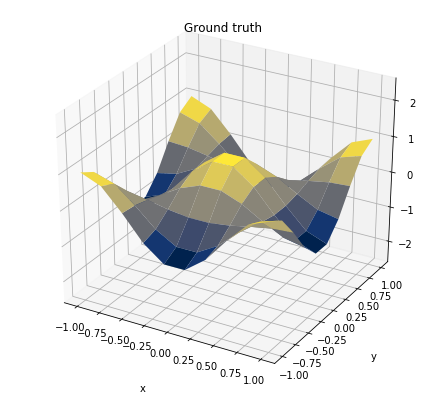

In [48]:
dim = 2 # dimension (trivial but necessary for generalization)
n = 10 # number of sample points by each coordinate
N = n*dim # sample size
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = 1 # frequence n associated to the variable y (see f1...f4)

C_f = (n_f*m_f)/2**dim # formule calculated by hand according to (Barron,1993-1994)
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,n)
x_2 = np.linspace(-1,1,n)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "cos"
f_2 = "cos"
num_sampling=32
num_epochs_not_seen = 1000
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)
#plot_base_function(X_1,X_2,1,1,fig_size=(1,1),fig_res=dpi)

fig = plt.figure(figsize=(17,7))

ax_1 = fig.add_subplot(1,2,1,projection='3d')
surf = ax_1.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)
 
# set axes label
ax_1.set_xlabel('x',labelpad=20)
ax_1.set_ylabel('y',labelpad=20)
ax_1.set_zlabel('z',labelpad=20)
ax_1.set_zlim(-2.5, 2.5)
ax_1.set_title('Ground truth')

In [182]:
random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
#topology = fully_connected_DAG(2,[9])
topology = sequential_DAG(2,[4,4])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.99
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

topology:
 [[0 0 1 1 1 1 0 0 0 0 0]
 [0 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]]


In [183]:
model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=200,
                                                                   topologies=[topology],learning_rates=[0.001],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=num_epochs_not_seen,
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f,
                                                                   num_plotting=num_sampling)

Parameters have been reset.
time - initialization of the NN:  0.0010013580322265625
Epoch:0  Step:0      Train loss:8360.6084    Test loss:0.12082     
Epoch:10 Step:10     Train loss:6.20474      Test loss:0.49812     
Epoch:20 Step:20     Train loss:0.0746       Test loss:0.80348     
Epoch:30 Step:30     Train loss:1.88006      Test loss:0.74348     
Epoch:40 Step:40     Train loss:3.43113      Test loss:0.68348     
Epoch:50 Step:50     Train loss:0.56366      Test loss:0.63769     
Epoch:60 Step:60     Train loss:0.16466      Test loss:0.48202     
Epoch:70 Step:70     Train loss:0.26547      Test loss:0.37584     
Epoch:80 Step:80     Train loss:1.15684      Test loss:0.26294     
Epoch:90 Step:90     Train loss:0.12101      Test loss:0.22782     
Epoch:101 Step:1      Train loss:0.97168      Test loss:0.15055     
Epoch:111 Step:11     Train loss:0.0084       Test loss:0.18018     
Epoch:121 Step:21     Train loss:0.02354      Test loss:0.15472     
Epoch:131 Step:31     Train l

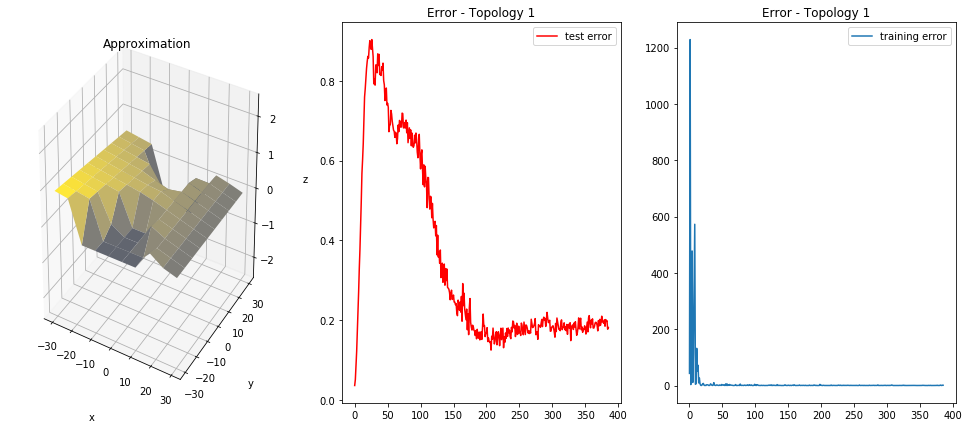

In [184]:
import warnings
warnings.filterwarnings("error")


x_1 = np.linspace(-1,1,N*2)
x_2 = np.linspace(-1,1,N*2)

Z_approx = model_approx[0](torch.Tensor(X_c)).detach().numpy().reshape(X_1.shape)
#plot_base_function(X_1,X_2,1,1,fig_size=(1,1),fig_res=dpi)

fig = plt.figure(figsize=(17,7))

ax_1 = fig.add_subplot(1,3,1,projection='3d')
surf = ax_1.plot_surface(X_1,X_2,Z_approx,cmap=plt.cm.cividis)
 
# set axes label
ax_1.set_xlabel('x',labelpad=20)
ax_1.set_ylabel('y',labelpad=20)
ax_1.set_zlabel('z',labelpad=20)
ax_1.set_zlim(-2.5, 2.5)
ax_1.set_title('Approximation')

plot_error([error_tr_evol[0][10:]],[error_test_evol[0][10:]],fig,1,3,2)

plt.savefig("./Images_runs/cos_n1_cos_m1.png")
plt.show()


9 does not have level 0
10 does not have level 0


Text(0.5, 1.0, 'Regions')

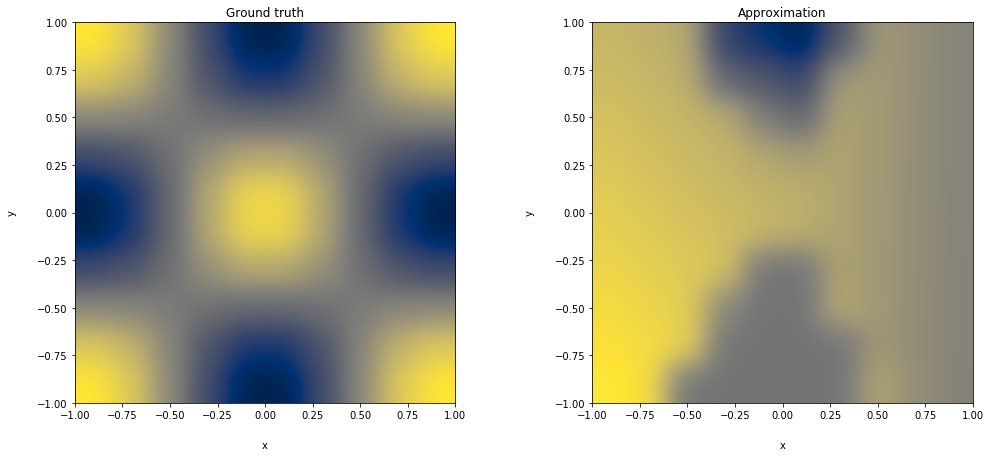

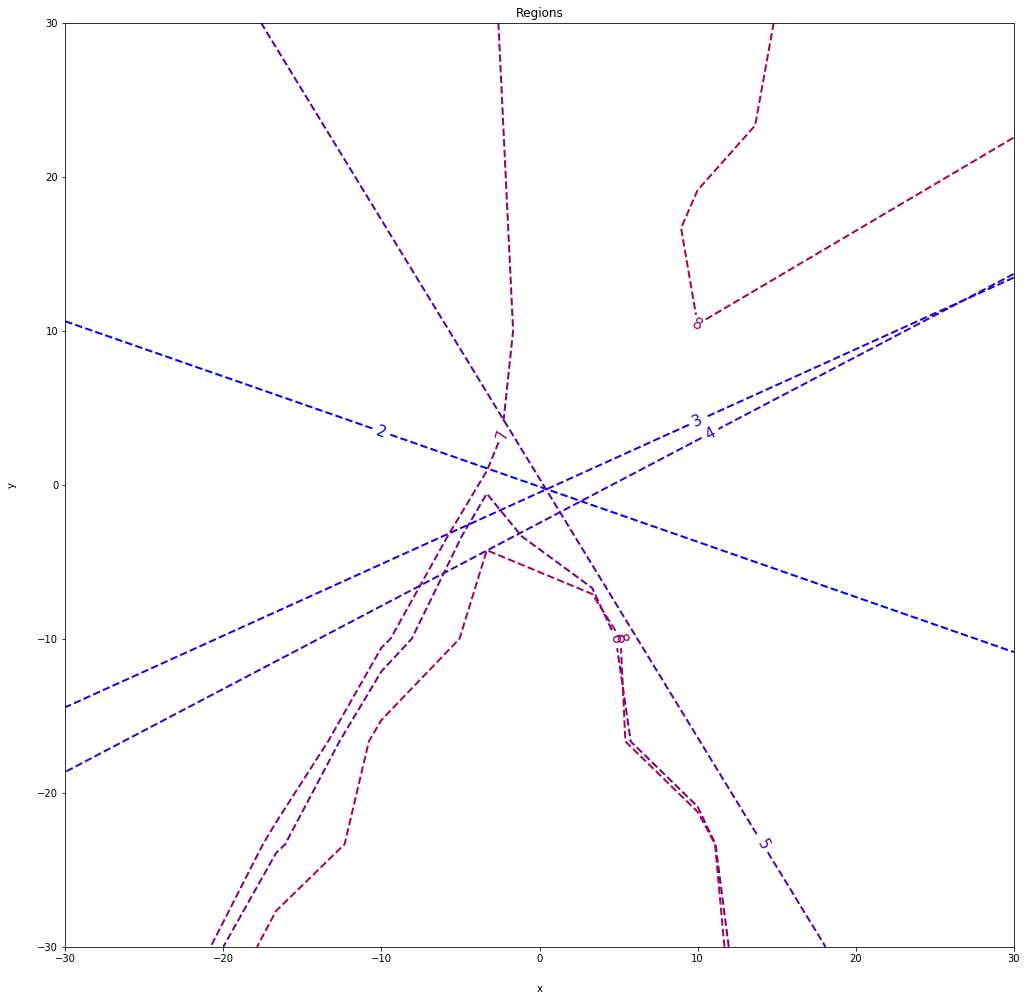

In [185]:
fig = plt.figure(figsize=(17,7))

# original function

ax = fig.add_subplot(1,2,1)
surf = ax.imshow(Z,extent=(-1,1,-1,1),origin='lower', interpolation='gaussian',cmap=plt.cm.cividis)
 
# set axes label
ax.set_xlabel('x',labelpad=20)
ax.set_ylabel('y',labelpad=20)
ax.set_title('Ground truth')

## approximation
ax = fig.add_subplot(1,2,2)
surf = ax.imshow(Z_approx,extent=(-1,1,-1,1),origin='lower', interpolation='gaussian',cmap=plt.cm.cividis)
 
# set axes label
ax.set_xlabel('x',labelpad=20)
ax.set_ylabel('y',labelpad=20)
ax.set_title('Approximation')

## regions
lim = 30
x_1 = np.linspace(-lim,lim,n)
x_2 = np.linspace(-lim,lim,n)
X_1,X_2 = np.meshgrid(x_1,x_2)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)

fig = plt.figure(figsize=(17,17))

ax = fig.add_subplot(1,1,1)
for i in range(dim,len(topology)):
    topology_i = topology[:i+1,:i+1]
    model_approx[0].change_topology(topology_i,reset_params=False)
    Z_approx_i = model_approx[0](torch.Tensor(X_c)).detach().numpy().reshape(X_1.shape)
    try:
        width = len(topology)-dim
        #contour = ax.contour(X_1,X_2,Z_approx_i,[0],colors=[plt.cm.RdYlBu(i-2)],linewidths=2,linestyles='dashed')
        level = 0
        bias = 0
        contour = ax.contour(X_1,X_2,Z_approx_i-bias,[level],colors=[[float(i-2)/float(width), 0.0, float(width-(i-2))/float(width)]],linewidths=2,linestyles='dashed')
        ax.clabel(contour, inline=True, fmt={level:str(i)}, fontsize=15)
    except:
        print(str(i)+" does not have level 0")

        
# set axes label
ax.set_xlabel('x',labelpad=20)
ax.set_ylabel('y',labelpad=20)
ax.set_title('Regions')

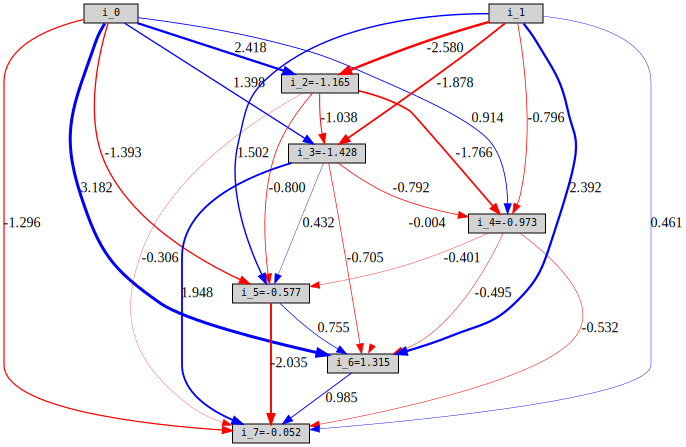

In [81]:
# values of the topology 1
x_tt = torch.Tensor(X_c[0])
graph_graphviz_v2 = Dot_graph(model_approx[0](x_tt), model=model_approx[0], instance=x_tt,show_attrs=False, show_saved=False)
#resize_graph(graph_graphviz, size_per_element=2, min_size=20)
graph_plot_gp2 = graph_graphviz_v2.make_dot_nn(instantiated=True)
graph_plot_gp2.render(filename="./Images_runs/cos_n1_cos_m1_network",format="png")
graph_plot_gp2

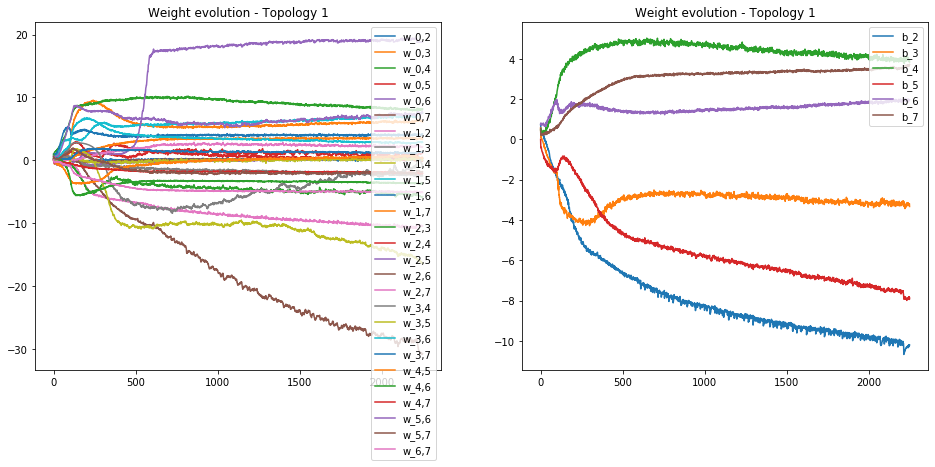

In [38]:
plot_weight_evolution(weight_evol,bias_evol,[model_approx[0].weight_names],[model_approx[0].bias_names])

In [137]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = 1 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "sin"
f_2 = "sin"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.1696535106103778
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0
Epoch:0  Step:0      Train loss:14.07444     Test loss:5.85739     
Epoch:1  Step:0      Train loss:0.00137      Test loss:0.32586     
Epoch:2  Step:0      Train loss:0.06207      Test loss:0.23843     
Epoch:3  Step:0      Train loss:0.2392       Test loss:0.24138     
Epoch:4  Step:0      Train loss:0.01965      Test loss:0.24145     
Epoch:5  Step:0      Train loss:0.01792      Test loss:0.23848     
Epoch:6  Step:0      Train loss:0.02266      Test loss:0.24508     
Epoch:7  Step:0      Train loss:0.08151      Test loss:0.25601     
Epoch:8  Step:0      Train loss:0.02172      Test loss:0.24829     
Epoch:9  Step:0      Train loss:1.13023      Test loss:0.24

In [138]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = 1 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "cos"
f_2 = "sin"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.1696535106103778
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0
Epoch:0  Step:0      Train loss:3.29101      Test loss:5.32812     
Epoch:1  Step:0      Train loss:0.03812      Test loss:0.25038     
Epoch:2  Step:0      Train loss:0.41695      Test loss:0.23918     
Epoch:3  Step:0      Train loss:0.00191      Test loss:0.21765     
Epoch:4  Step:0      Train loss:0.00782      Test loss:0.21419     
Epoch:5  Step:0      Train loss:0.00514      Test loss:0.22523     
Epoch:6  Step:0      Train loss:0.17459      Test loss:0.21293     
Epoch:7  Step:0      Train loss:0.87226      Test loss:0.21219     
Epoch:8  Step:0      Train loss:0.0          Test loss:0.20639     
Epoch:9  Step:0      Train loss:0.00354      Test loss:0.22

In [139]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = 1 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "sin"
f_2 = "cos"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.1696535106103778
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0
Epoch:0  Step:0      Train loss:7.65454      Test loss:5.78568     
Epoch:1  Step:0      Train loss:0.24276      Test loss:0.41318     
Epoch:2  Step:0      Train loss:0.00477      Test loss:0.34775     
Epoch:3  Step:0      Train loss:0.68142      Test loss:0.34301     
Epoch:4  Step:0      Train loss:0.38966      Test loss:0.34346     
Epoch:5  Step:0      Train loss:0.53501      Test loss:0.37423     
Epoch:6  Step:0      Train loss:0.04905      Test loss:0.34339     
Epoch:7  Step:0      Train loss:0.63664      Test loss:0.35035     
Epoch:8  Step:0      Train loss:0.16132      Test loss:0.3625      
Epoch:9  Step:0      Train loss:0.02541      Test loss:0.34

In [ ]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = 1 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "sin"
f_2 = "cos"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

## Test 1D

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  -0.1696535106103778


Text(0.5, 0.92, 'Ground truth')

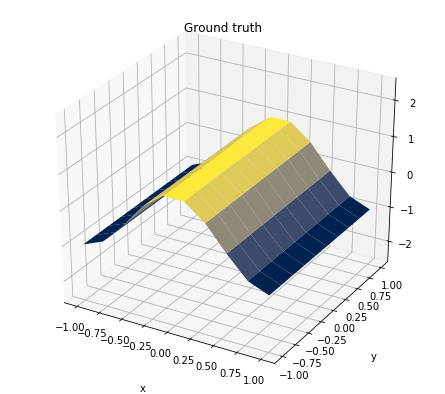

In [179]:
N = 10 # number of sample points
n_f = 1 # frequence n associated to the variable x (see f1...f4)
m_f = -1 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "cos"
f_2 = "cos"
Z = eval("np."+f_1)(n_f*np.pi*X_1)
#plot_base_function(X_1,X_2,1,1,fig_size=(1,1),fig_res=dpi)

fig = plt.figure(figsize=(17,7))

ax_1 = fig.add_subplot(1,2,1,projection='3d')
surf = ax_1.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)
 
# set axes label
ax_1.set_xlabel('x',labelpad=20)
ax_1.set_ylabel('y',labelpad=20)
ax_1.set_zlabel('z',labelpad=20)
ax_1.set_zlim(-2.5, 2.5)
ax_1.set_title('Ground truth')

In [181]:
random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = sequential_DAG(2,[2])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=600,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

topology:
 [[0 0 1 1 0]
 [0 0 1 1 0]
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]
time - initialization of the NN:  0.01807999610900879
Epoch:0  Step:0      Train loss:3.04613      Test loss:1.98854     
Epoch:1  Step:0      Train loss:0.36312      Test loss:0.42689     
Epoch:2  Step:0      Train loss:0.55392      Test loss:0.63851     
Epoch:3  Step:0      Train loss:1.40776      Test loss:0.60206     
Epoch:4  Step:0      Train loss:0.27282      Test loss:0.6152      
Epoch:5  Step:0      Train loss:0.47684      Test loss:0.56695     
Epoch:6  Step:0      Train loss:0.00149      Test loss:0.51781     
Epoch:7  Step:0      Train loss:0.53853      Test loss:0.64968     
Epoch:8  Step:0      Train loss:1.37547      Test loss:0.58978     
Epoch:9  Step:0      Train loss:0.43461      Test loss:0.52841     
Epoch:10 Step:0      Train loss:0.70674      Test loss:0.54821     
Epoch:11 Step:0      Train loss:0.61928      Test loss:0.55692     
Epoch:12 Step:0      Train loss:1.33905      Test los

## 3.2. n=2 and m=2

We know that we need more than 13 neurons in the hidden layers.

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.5074544964718078


Text(0.5, 0.92, 'Ground truth')

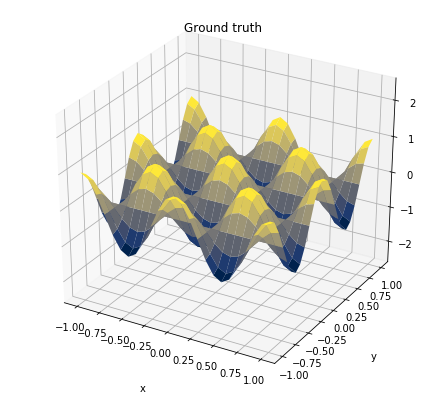

In [182]:
## sin(n*x)*sin(m*x) with n=m=1

N = 25 # number of sample points
n_f = 2 # frequence n associated to the variable x (see f1...f4)
m_f = 2 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "cos"
f_2 = "cos"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)
#plot_base_function(X_1,X_2,1,1,fig_size=(1,1),fig_res=dpi)

fig = plt.figure(figsize=(17,7))

ax_1 = fig.add_subplot(1,2,1,projection='3d')
surf = ax_1.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)
 
# set axes label
ax_1.set_xlabel('x',labelpad=20)
ax_1.set_ylabel('y',labelpad=20)
ax_1.set_zlabel('z',labelpad=20)
ax_1.set_zlim(-2.5, 2.5)
ax_1.set_title('Ground truth')

In [194]:


random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[18])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[1],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

topology:
 [[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0169620

In [141]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 2 # frequence n associated to the variable x (see f1...f4)
m_f = 2 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "sin"
f_2 = "sin"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.6786140424415112
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0020971298217773438
Epoch:0  Step:0      Train loss:1.90811      Test loss:4.74479     
Epoch:1  Step:0      Train loss:0.17733      Test loss:0.30416     
Epoch:2  Step:0      Train loss:0.11174      Test loss:0.18683     
Epoch:3  Step:0      Train loss:0.23956      Test loss:0.18422     
Epoch:4  Step:0      Train loss:0.67524      Test loss:0.19521     
Epoch:5  Step:0      Train loss:0.3391       Test loss:0.18311     
Epoch:6  Step:0      Train loss:0.00465      Test loss:0.18066     
Epoch:7  Step:0      Train loss:0.09379      Test loss:0.19212     
Epoch:8  Step:0      Train loss:0.00203      Test loss:0.21488     
Epoch:9  Step:0      Train loss:0.00797  

In [142]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 2 # frequence n associated to the variable x (see f1...f4)
m_f = 2 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "cos"
f_2 = "sin"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.6786140424415112
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0010008811950683594
Epoch:0  Step:0      Train loss:0.1436       Test loss:7.66557     
Epoch:1  Step:0      Train loss:0.03282      Test loss:0.3112      
Epoch:2  Step:0      Train loss:0.0034       Test loss:0.14142     
Epoch:3  Step:0      Train loss:0.79319      Test loss:0.16426     
Epoch:4  Step:0      Train loss:0.0006       Test loss:0.14422     
Epoch:5  Step:0      Train loss:0.09224      Test loss:0.20016     
Epoch:6  Step:0      Train loss:0.27578      Test loss:0.18323     
Epoch:7  Step:0      Train loss:0.47114      Test loss:0.15815     
Epoch:8  Step:0      Train loss:0.03836      Test loss:0.14686     
Epoch:9  Step:0      Train loss:0.00768  

In [143]:
## sin(n*x)*sin(m*x) with n=m=1

N = 10 # number of sample points
n_f = 2 # frequence n associated to the variable x (see f1...f4)
m_f = 2 # frequence n associated to the variable y (see f1...f4)
dim = 2 # dimension (trivial but necessary for generalization)
C_f = (n_f*m_f)/2**dim
neurons_l1 = max(int(np.ceil(C_f*(N/(dim*np.log(N)))**(1/2))),dim+1) # neurons at the 1st hidden layer
error_approx = C_f*((dim/N)*np.log(N))**(1/2) # order of the error
print("number of neurons according to (Barron,1993-1994): ",neurons_l1)
print("approximation error according to (Barron,1993-1994): ",error_approx)
x_1 = np.linspace(-1,1,N)
x_2 = np.linspace(-1,1,N)
X_1,X_2 = np.meshgrid(x_1,x_2)
f_1 = "sin"
f_2 = "cos"
Z = eval("np."+f_1)(n_f*np.pi*X_1)*eval("np."+f_2)(m_f*np.pi*X_2)

random_state = 0

#topology = fully_connected_DAG(dim,1,num_nodes=dim+neurons_l1+1)
topology = fully_connected_DAG(2,[5])
print("topology:\n",topology)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
Z_c = np.array(Z).reshape(-1,1)
fraction_train = 0.75
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z_c,train_size=fraction_train,random_state=random_state)

model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=10e-12,max_epochs=2100,
                                                                   topologies=[topology],learning_rates=[0.02],lambda_=0.0,
                                                                   gamma_=0.0, num_epochs_not_seen=int(N*N*fraction_train),
                                                                   X_1=X_1,X_2=X_2,X_c=X_c,f_1=f_1,n_f=n_f,f_2=f_2,m_f=m_f)

number of neurons according to (Barron,1993-1994):  3
approximation error according to (Barron,1993-1994):  0.6786140424415112
topology:
 [[0 0 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1]
 [0 0 0 1 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]]
time - initialization of the NN:  0.0009984970092773438
Epoch:0  Step:0      Train loss:9.69324      Test loss:6.60206     
Epoch:1  Step:0      Train loss:0.00845      Test loss:0.39531     
Epoch:2  Step:0      Train loss:0.01117      Test loss:0.39852     
Epoch:3  Step:0      Train loss:0.60698      Test loss:0.40786     
Epoch:4  Step:0      Train loss:1.18337      Test loss:0.40215     
Epoch:5  Step:0      Train loss:1.2627       Test loss:0.38322     
Epoch:6  Step:0      Train loss:0.55597      Test loss:0.35845     
Epoch:7  Step:0      Train loss:0.19233      Test loss:0.39167     
Epoch:8  Step:0      Train loss:0.58672      Test loss:0.36077     
Epoch:9  Step:0      Train loss:0.16311  

## 4. Code to merge the images about the evolution of the error and the neural architecture

In [177]:
from PIL import Image
#Read the two images

list_epochs = [0]
list_epochs = list_epochs+[2**i for i in range(11)]
print(list_epochs)
list_f_1 = ['cos','sin']
list_f_2 = ['cos','sin']

for epoch in list_epochs:
    for f_1 in list_f_1:
        for f_2 in list_f_2:
            try:
                image1 = Image.open('./Images_runs/network_'+str(f_1)+'_1_'+str(f_2)+'_1_'+str(epoch)+'.png')
                image2 = Image.open('./Images_runs/error_'+str(f_1)+'_1_'+str(f_2)+'_1_'+str(epoch)+'.png')
                #resize, first image
                image2_size = image2.size
                image1_size = image1.size
                new_image = Image.new('RGB',(image2_size[0], 2*image1_size[1]), (250,250,250))
                new_image.paste(image1,(0,0))
                new_image.paste(image2,(-100,image1_size[1]))
                new_image.save("./Images_runs/evolution/"+str(f_1)+"_1_"+str(f_2)+"_1_"+str(epoch)+".png","png")
            except:
                print("there was an error with epoch: ",epoch,", f_1: ",f_1,", f_2: ",f_2)


[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
there was an error with epoch:  1024 , f_1:  sin , f_2:  sin


## 5. Code to plot and save many 2d basis functions [in testing phase]

In [ ]:
# plot a figure of size (100,100) pixels
dpi = 100 # it should be greater than or equal to sample_size

# # generating functions for 0<=n,m<=sample_size/2<=N_max=dpi/2
# for i in range(int(sample_size/2)):
#     for j in range(int(sample_size/2)):
#         plot_base_function(X1,X2,i,j,fig_size=(1,1),fig_res=dpi)
# ;

## 6. generating random functions from a neural network

Let's generate 100x100 points.

In [61]:
n_1 = 500
N = n_1*n_1
num_nodes = 7
num_nn_instances = 20
topology = fully_connected_DAG(dim_input=2,units_in_layers=[num_nodes-3],dim_output=1)
print(topology)

[[0 0 1 1 1 1 1]
 [0 0 1 1 1 1 1]
 [0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 0 1 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]


In [66]:
model = function_approximator(topology)
model.reset_parameters(distribution=["normal","normal"],
                         params=[[0.0,1.0],[0.0,1.0]])

lim = 20
x_1 = np.linspace(-lim,lim,n_1)
x_2 = np.linspace(-lim,lim,n_1)
X_1,X_2 = np.meshgrid(x_1,x_2)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = torch.Tensor(np.array(X_c).reshape(-1,2))
x_tt = X_c[0]

time - initialization of the NN:  0.0026044845581054688


In [63]:
#Z = model(X_c[0]).detach().numpy()
Z = model(X_c).detach().numpy().reshape(n_1,-1)
print(X_1.shape,X_2.shape,Z.shape)

(500, 500) (500, 500) (500, 500)


In [44]:
# num_nodes = num_edges
# nodes = list(range(2,num_nodes))
# edges = [[model.non_zero_entries[0][i],model.non_zero_entries[1][i]] for i in range(len(model.non_zero_entries[0]))]

In [45]:
# from graphviz import Digraph

# G = Digraph(comment='NN Architecture')
# G.node_attr.update(shape='box', style='rounded')
# for idx in range(len(nodes)):
# #     if n[0] == str(y_argmax) and n[1] == p_max:
# #         G.node(n[0],label='''<{<B>%s</B> | %3.2f}>''' % (n[0],n[1]),shape='record',fontcolor='blue')
# #     else:
#     G.node(str(nodes[idx]),label='''<{<B>%s</B> | %3.2f}>''' % (str(nodes[idx]),model.biases[idx]),shape='record')
# for idx in range(len(edges)):
#     G.edge(str(edges[idx][0]),str(edges[idx][1]),"%3.2f" % model.weights[idx])
# # print(G)
# G.render('NN Architecture', view=True)

Text(0.5, 0.92, 'Expressible function')

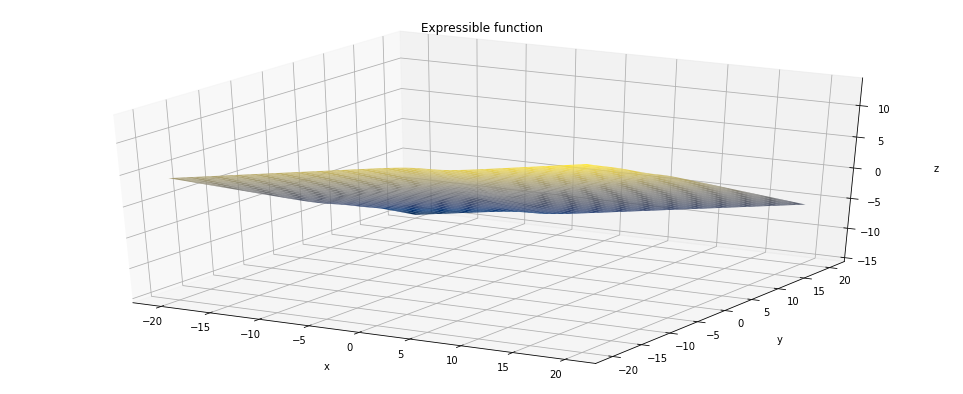

In [64]:
fig = plt.figure(figsize=(17,7))
ax_1 = fig.add_subplot(1,1,1,projection='3d')
surf = ax_1.plot_surface(X_1,X_2,Z,cmap=plt.cm.cividis)
 
# set axes label
ax_1.set_xlabel('x',labelpad=20)
ax_1.set_ylabel('y',labelpad=20)
ax_1.set_zlabel('z',labelpad=20)
#ax_1.set_zlim(-2.5, 2.5)
ax_1.set_title('Expressible function')

In [73]:
f_1 = 'cos'
f_2 = 'cos'
n_f = 1
m_f = 1
epochs = 0
save_plots_evolution(model,x_tt[0],X_1,X_2,X_c,
                            f_1,n_f,f_2,m_f,epochs)

## Finding the minimum number of data points to approximate exactly an expressible funcion

In [141]:
import numpy as np
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [182]:


n_1 = 100
N = n_1*n_1
num_nodes = 7
num_nn_instances = 9
mean = 0
std_dev = 1
random_state = 0
fraction_train = [(i+1)/(num_nn_instances+1) for i in range(num_nn_instances)]

# data points to be used
x_1 = np.linspace(-1,1,n_1)
x_2 = np.linspace(-1,1,n_1)
X_1,X_2 = np.meshgrid(x_1,x_2)

X_c = []
for i in range(len(X_1)):
    for j in range(len(X_1[0])):
        X_c.append([X_1[i,j],X_2[i,j]])

X_c = np.array(X_c).reshape(-1,2)
X_tt = torch.Tensor(X_c)


# fully-connected-DAG
topology = fully_connected_DAG(2,1,num_nodes=num_nodes)

In [38]:
fraction_train = 0.75
model = function_approximator(topology)
model.reset_parameters(distribution=["normal","normal"],
                         params=[[mean,std_dev],[mean,std_dev]])
list_models.append(model)
Z = model(X_tt).detach().numpy().reshape(-1,1)
X_tr,X_val,Z_tr,Z_val = train_test_split(X_c,Z,train_size=fraction_train,random_state=random_state)
    
# let's suppose that we know exactly the topology
model_approx,error_tr_evol,error_test_evol,weight_evol,bias_evol,epochs = train_model(X_tr,Z_tr,X_val,Z_val,error=0.0,topologies=[topology],
                                                                   learning_rates=[0.1],lambda_=0.0,
                                                                   gamma_=0.0)
list_models.append(model_approx[0])
list_epochs.append(epochs[0])

time - initialization of the NN:  0.0009906291961669922


NameError: name 'mean' is not defined

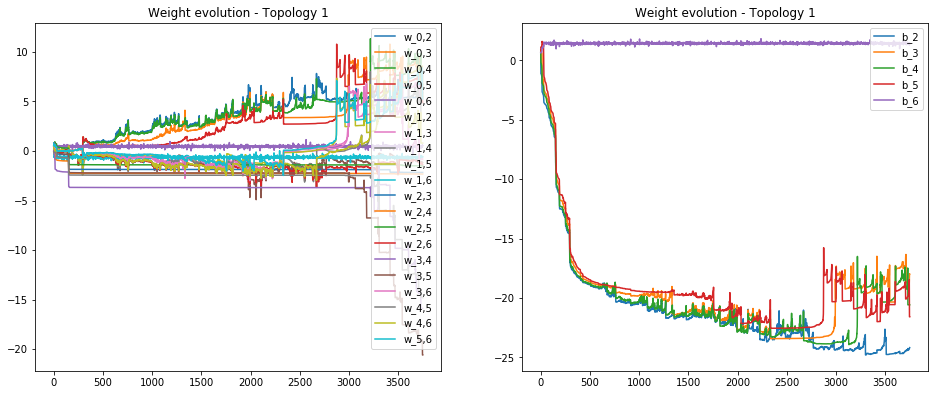

In [247]:
plot_weight_evolution(weight_evol,bias_evol,[model_approx[0].weight_names],[model_approx[0].bias_names])

In [222]:
print("real weights:\n",model.weights,"\nreal biases:\n",model.biases)

real weights:
 Parameter containing:
tensor([ 0.7238, -0.7188, -0.6231, -0.4558, -0.9773, -0.0188, -1.5802, -1.4824,
        -1.3807,  0.2070,  1.2159, -0.4980,  1.7545,  0.8147,  1.3665,  0.6501,
        -0.2580,  1.9706, -0.3673, -0.3628], requires_grad=True) 
real biases:
 Parameter containing:
tensor([-0.0588, -0.9556, -0.2475,  0.3464,  0.1406], requires_grad=True)


In [219]:
print(error_tr_evol[0])
print(error_test_evol[0])

[0.817754864692688, 0.014654632657766342, 0.007650687359273434, 0.00784525740891695]
[tensor(2.4946), tensor(0.5968), tensor(0.5312), tensor(0.5143)]


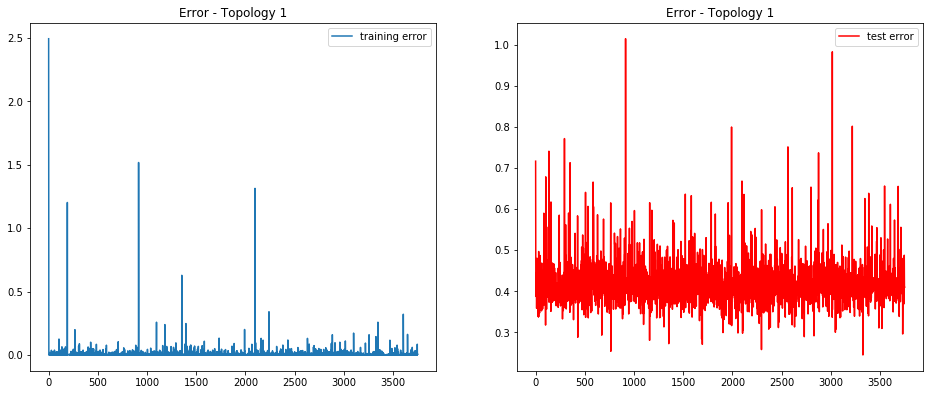

In [248]:
plot_error(error_tr_evol,error_test_evol)

In [ ]:
list_models = []
list_epochs = []
list_models_approx = []

for idx_fr in [range(len(fraction_train)-1,-1,-1)]:
    model = function_approximator(topology)
    model.reset_parameters(distribution=["normal","normal"],
                         params=[[mean,std_dev],[mean,std_dev]])
    list_models.append(model)
    Z = model(X_tt).detach().numpy().reshape(-1,1) 
    X_tr,_,Z_tr,_ = train_test_split(X_c,Z,train_size=fraction_train[idx_fr],random_state=random_state)
    
    
    # let's suppose that we know exactly the topology
    model_approx,_,_,epochs = train_model(X_tr,Z_tr,error=0.0,topologies=[topology],learning_rates=[0.1])
    list_models.append(model_approx[0])
    list_epochs.append(epochs[0])

## 3. Architecture search

In [ ]:
import warnings
warnings.filterwarnings("error")


def train_model_search(X,Y,error:float,topologies:list,learning_rates:list,
                       lambda_:float=0,epsilon_=):
    
    '''
    lambda_: regularization parameter (norm 2)
    epsilon_: architecture search parameter (to compare with each model parameter after each epoch)
            If the parameter is less than or equal to epsilon, apply zero operation
    '''

    # data as tensors
    x_tt = torch.Tensor(X).to(device)
    y_tt = torch.Tensor(Y).to(device)
    
    num_steps = len(X)                       # this is a model with a single batch and num_steps is the his size
    idx_list = np.arange(num_steps)          # index of the elements in the batch
    date = datetime.now()

    idx_topo = 0
    list_models = []
    list_error_models = []
    list_error = []
    list_weight_values_models = []
    list_weight_values = []
    list_bias_values_models = []
    list_bias_values = []
    list_epochs = []

    ## training phase
    for topo in topologies:
        # change the topologie of the network
        neural_network_graph = topo
        model = function_approximator(neural_network_graph).to(device)

        for l_r in learning_rates:
            # instatiation of the weights
            model.reset_parameters()

            # variables for sampling
            num_epochs_not_seen = 1000   # frequency of the sampling for tensorboard
            num_sampling = 50 # frequency of sampling for weights and biases evolution
            loss = error + 1
            epochs = 0
            while(loss > error and epochs < 25):
                #optimizer = torch.optim.SGD(model.parameters(), lr=l_r)
                optimizer = torch.optim.Adam(model.parameters(), lr=l_r/(1+epochs))
                
                # sorting indirectly the points evaluated at each epoch in order to make the output model more general
                np.random.shuffle(idx_list)
                for j in range(num_steps):
                    data_point = idx_list[j]
                    #data_point = np.random.randint(len(X))
                    x_var = x_tt[data_point].float()
                    y_var = y_tt[data_point].float()

                    optimizer.zero_grad()                               # make the gradient vector zero at the beginning
                    y_hat = model(x_var)                                # forward phase

                    loss = model.loss(y_hat, y_var, lambda_)
                    loss.backward(retain_graph=False)                   # backward phase
                    optimizer.step()                                    # weight ajustement

                    if(int(epochs*num_steps + j) % num_epochs_not_seen == 0):
                        print('Epoch: {0},\tStep: {1},\tLoss: {2}'.format(epochs, j, loss.cpu().data.numpy()))

                    elif(epochs*num_steps + j == epochs*num_steps-1):
                        print('Epoch: {0},\tStep: {1},\tLoss: {2}'.format(epochs, j, loss.cpu().data.numpy()))
                        
                    if(int(epochs*num_steps + j) % num_sampling == 0):
                        list_error.append(loss.cpu().item())
                        list_weight_values.append(list(model.weights.cpu().data.numpy()))
                        list_bias_values.append(list(model.biases.cpu().data.numpy()))
                
                epochs += 1
                for i in range(len()):
                    if(list_weight_values[-1][i] <= epsilon):
                        topology model.non_zero_entries[0][i],model.non_zero_entries[0][j]
                        weights_zero = [0 for weight in np.array( if weight <= epsilon_)

            list_models.append(model)
            list_error_models.append(list_error)
            list_error = []
            list_weight_values_models.append(list_weight_values)
            list_weight_values = []
            list_bias_values_models.append(list_bias_values)
            list_bias_values = []
            list_epochs.append(epochs)
        

        idx_topo += 1
    
    return list_models,list_error_models,list_weight_values_models,list_bias_values_models,list_epochs